In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils, similarity_utils

/n/fs/ac-project/anaconda3/envs/vlm-lens-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Util Functions

In [ ]:
# For each layer, calculate the mean similarity and the norm
def plot_similarities(module_names,
                      module_embeddings,
                      module_similarities,
                      vision_key,
                      model_name=''):
    '''
    Given list of module names, image embeddings (vision and text + vision), and similarities
    plot mean similarity score for each layer

    Arg(s):
        module_names : list[str]
        module_embeddings : list[2D np.array]
        module_similarities : list[1D np.array]
    '''
    mean_embeddings = {}
    mean_similarities = {}
    for idx, (name, embs, sims) in enumerate(zip(module_names, module_embeddings, module_similarities)):
        # Key is based on vision vs text
        key = name.split(".")[0]
        # If we are isolating vision token embeddings
        if "-" in name:
            key += "-{}".format(name.split("-")[1])
        if key in mean_embeddings:
            mean_embeddings[key].append(np.mean(embs))
        else:
            mean_embeddings[key] = [np.mean(embs)]

        if key in mean_similarities:
            mean_similarities[key].append(np.mean(sims))
        else:
            mean_similarities[key] = [np.mean(sims)]

    # Plot mean image-pair similarity scores by layer
    xs = []
    ys = []
    labels = []
    n_vision_layers = len(mean_embeddings[vision_key])
    for k, v in mean_similarities.items():
        if k.startswith("model"):
            xs.append([i + n_vision_layers for i in range(len(v))])
        else:
            xs.append([i for i in range(len(v))])
        ys.append(v)
        labels.append("{} blocks".format(k))

    print(ys)
    visualizations.plot(
        xs=xs,
        ys=ys,
        labels=labels,
        alpha=0.8,
        xlabel='Layer of {} Model'.format(model_name),
        ylabel='Mean Image Pairwise Similarity (0-1)',
        show=True
    )


# Run model; collect image-pair similarities at each layer; compute mean at each layer; graph similarity score vs layer

In [37]:
# TODO: Update config file
# Qwen2-VL-2B-Instruct
# config_path = '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualBlocks.yaml'
# Qwen2-VL-7B-Instruct
# config_path = '../configs/models/qwen/Qwen2-VL-7B-Instruct-VisualBlocks.yaml'
# LLaVA-1.5-7B
config_path = '../configs/models/llava/LLaVA-1.5-7B-VisualBlocks.yaml'

sys.argv = ['notebooks/track_mean_sims_across_layers.ipynb',
            '--config', config_path]

config = Config()
model = get_model(config.architecture, config)
print("Using {}".format(config.get_model_id()))
# Print # parameters and model architecture
print("{:.3f}B parameters".format(model.model.num_parameters() / 1e9))
print(model.model)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 11.49it/s]


Using llava-1.5-7b-hf
7.063B parameters
LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): C

In [38]:
n_modules = 0
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)
        n_modules += 1
print("{} modules matched".format(n_modules))

vision_tower.vision_model.encoder.layers.0
vision_tower.vision_model.encoder.layers.1
vision_tower.vision_model.encoder.layers.2
vision_tower.vision_model.encoder.layers.3
vision_tower.vision_model.encoder.layers.4
vision_tower.vision_model.encoder.layers.5
vision_tower.vision_model.encoder.layers.6
vision_tower.vision_model.encoder.layers.7
vision_tower.vision_model.encoder.layers.8
vision_tower.vision_model.encoder.layers.9
vision_tower.vision_model.encoder.layers.10
vision_tower.vision_model.encoder.layers.11
vision_tower.vision_model.encoder.layers.12
vision_tower.vision_model.encoder.layers.13
vision_tower.vision_model.encoder.layers.14
vision_tower.vision_model.encoder.layers.15
vision_tower.vision_model.encoder.layers.16
vision_tower.vision_model.encoder.layers.17
vision_tower.vision_model.encoder.layers.18
vision_tower.vision_model.encoder.layers.19
vision_tower.vision_model.encoder.layers.20
vision_tower.vision_model.encoder.layers.21
vision_tower.vision_model.encoder.layers.2

In [39]:
# Run model on images
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


In [40]:
# Compute image-pair similarities per layer
db_path = model.config.output_db
utils.informal_log("Database path: {}".format(db_path))

module_names, module_embeddings, module_similarities = similarity_utils.compute_image_pair_similarities(
    database_path=db_path,
    model=model,
    layer_names=None,
    modalities=['vision', "text+vision"])

[1021_121858] Database path: ../output/LLaVA-1.5-7B-VisualBlocks.db


100%|██████████| 58/58 [02:10<00:00,  2.24s/it]


[[np.float64(0.6454540821904928), np.float64(0.6579921058479008), np.float64(0.7203864208240505), np.float64(0.5967381336775882), np.float64(0.5831583619548621), np.float64(0.6109073661276837), np.float64(0.4607822205452046), np.float64(0.489295550901659), np.float64(0.5440468529118285), np.float64(0.5833899296517208), np.float64(0.6196754660096279), np.float64(0.6560578064279516), np.float64(0.7528303779260517), np.float64(0.7351160513525606), np.float64(0.7065064676129151), np.float64(0.7305404475856122), np.float64(0.7219008036944902), np.float64(0.743022857330232), np.float64(0.769988172352867), np.float64(0.8410390057076481), np.float64(0.9368044230702547), np.float64(0.9082324769683413), np.float64(0.8793468395810649), np.float64(0.9170719784162853)], [np.float64(0.6454540821904928), np.float64(0.6579921058479008), np.float64(0.7203864208240505), np.float64(0.5967381336775882), np.float64(0.5831583619548621), np.float64(0.6109073661276837), np.float64(0.4607822205452046), np.floa

<Figure size 640x480 with 0 Axes>

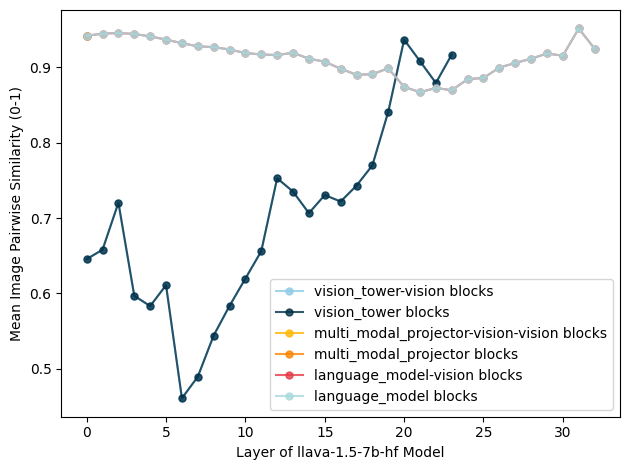

In [43]:
# Computer mean similarity at each layer (using vision or vision + text)
# and plot

plot_similarities(
    module_names=module_names,
    module_embeddings=module_embeddings,
    module_similarities=module_similarities,
    vision_key=model.get_vision_key(),
    model_name=model.config.get_model_id())

# LLaVA-1.5-7B

In [15]:
sys.argv = ['notebooks/track_mean_sims_across_layers.ipynb',
            '--config', '../configs/models/llava/LLaVA-1.5-7B-VisualBlocks.yaml']

config = Config()
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


In [16]:
print("{:.3f}B parameters".format(model.model.num_parameters() / 1e9))
print(model.model)

7.063B parameters
LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              